# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Introduction to Data Science

## Lab 6: CNNs, Autoencoders, Tensorflow Datasets, and Transfer Learning

**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb<br/>
<br/>

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

<a id="contents"></a>

## Notebook Contents
- [**Keras for CNNs**](#keras)
    - [Layers of a CNN in Keras](#keras_layers)
    - [**Exercise:** Building a CNN from Scratch](#build_cnn)
- [**CNNs and Autoencoders with KMNIST**](#kmnist)
    - [Baseline CNN Classifier](#baseline)
    - [**Exercise:** Improving on Baseline Model](#improving)
- [**Tensorflow Datasets**](#tfdatasets)
    - [Loading Datasets](#loadds)
    - [The Dataset Object](#dsobj)
    - [Take, Cardinality, & Batch](#take)
    - [Cache, Prefetch, & Shuffle](#cache)
    - [Preprocessing with Datasets](#dspreproc)
    - [Data Augmentation](#dataaug)
- [**Transfer Learning**](#transfer_learning)
    - [MobileNet](#mobilenet)

    

In [2]:
# Check if GPU is available and visible to TensorFlow
import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

2025-03-07 07:05:29.757111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 07:05:29.757172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 07:05:29.788154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 07:05:29.854588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU found


2025-03-07 07:05:55.654623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:31:00.0, compute capability: 8.9


<a id='keras'></a>
## Keras [^](#contents "Back to Contents")


The <a href='https://keras.io/'>Keras API</a> sits on top of Tensorflow. It allows users to work at a more intuitive level of abstraction where the basic objects are **layers**.
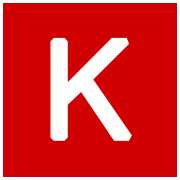

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [4]:
# Ensure replicable results
import os
import random as rn
SEED = 109
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [5]:
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, GaussianNoise
from keras.layers import GlobalAveragePooling2D, Input, MaxPool2D, MaxPooling2D, RandomRotation, UpSampling2D
from keras.models import Model, Sequential
from keras import losses
from keras import optimizers
from keras import layers
from keras import callbacks

<div id="keras_layers" class='exercise'><b>Layers of a CNN in Keras</b></div></br>
<img src='fig/cnn1.png' width='900px'>

The following is a list of layers commonly used when building CNNs with Keras.<br>
A link to the official documentation for each layer is also provided.

<div id="build_cnn" class='exercise'><b>Build a CNN from Scratch</b></div></br>

Now let's try building a CNN model with a similar architecture to [**LeNet**](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) from scratch, using the layers below.

In [6]:
# Build our LeNet model from scratch with Keras Function API

# The expected input size is 32x32 grayscale images
# your code here
inputs = Input(shape=(32, 32, 1))

# Convolution Layer 1: 6 filters of size 5x5, stride=1, no padding
# your code here
x = Conv2D(6, 5, strides=1, padding='valid', activation='relu')(inputs)

# Pooling Layer 1: Max Pooling with pool size 2x2, stride 2
# your code here
x = MaxPooling2D(2, strides=2)(x)

# Convolution Layer 2: 16 filters of size 5x5, stride=1, no padding
# your code here
x = Conv2D(16, 5, strides=1, padding='valid', activation='relu')(x)

# Pooling Layer 2: Max Pooling with pool size 2x2, stride 2
# your code here
x = MaxPooling2D(2, strides=2)(x)

# Convolution Layer 3: 120 filters of size 5x5
# your code here
x = Conv2D(120, 5, strides=1, padding='valid', activation='relu')(x)

# Flatten before fully-connected layers
# your code here
x = Flatten()(x)

# Fully Connected Layer: 84 units with relu activation
# your code here
x = Dense(84, activation='relu')(x)

# Output Layer: [10-class Image Classification Task]
# your code here
outputs = Dense(10, activation='softmax')(x)

# Instantiate your model
# your code here
simple_cnn = Model(inputs=inputs, outputs=outputs)
simple_cnn.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120 

2025-03-07 07:05:57.118713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:31:00.0, compute capability: 8.9


### Input

[**tf.keras.Input**](https://www.tensorflow.org/api_docs/python/tf/keras/Input)(
    shape=None, **kwargs
)

<div style='color:red'><strong>The input is not a layer!</strong></div>

As Pavlos said in lecture, you shouldn't think of the input to your network as a layer. Unfortunately, in Keras, most components of a network are referred to as 'layers'. Someone must have come to their senses because now `Input` can be found in the base `tf.keras` module. While it *can* still be imported from `tf.keras.layers`, we are civilized people and shall speak no more of that.

The network will be expecting input of fixed shape which must be specified with the `shape` parameter. You should look at the data you are using to determine this shape.

Adding an explicit `Input` object to your layer is not required as most layers have an `input_shape` that can be specified if they are the first layer in the network.



### 2D Convolutional Layers

[**keras.layers.Conv2D**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', data_format='channels_last', 
                    bias_initializer='zeros')

<img src='fig/conv-many-filters.png' width='550px'>

**Some quick review if skipping to this section:**

A convolutional layer is composed of **filters**, which are composed of **kernels** which are themselves composed of **weights**. Each filter also has a bias term though it is often not depicted in diagrams (it is exluded in the one above for example). We learn the weights and biases from our data. Each conv layer also has an associated **activation function** such as ReLU or sigmoid. 

The **number of filters** and the **height and width of the kernels** of which they consist are set by the `filters` and `kernel_size` (a tuple) arguments respectively. 

The **depth of the filters is fixed** by the depth (i.e., 'channels' or 'filter maps') of the input to the conv layer. 

The output of the conv layer is is a 3D tensor which is a set of **feature maps**. Each feature map is itself the output of one of the layer's filters convolving on the input. The height and width of the feature map tensor is determined by the input size, `kernel_size`, `padding`, and `stride`. The depth of the output tensor (i.e, number of feature maps) is equal to the number of filters in the layer.
                    
Keras also has a [1D convolutional layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) used for time series data and a [3D convolutional layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D) used for video.

### Pooling Layers

[**keras.layers.MaxPool2D**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

<img src='fig/maxpool.png' alt='MaxPool' width='400px'>

Pooling layers are also comprised of filters and feature maps. Let's say the pooling layer has a 2x2 receptive field and a stride of 2. This stride results in feature maps that are one half the size of the input feature maps. We can use a max() operation for each receptive field. 

### Flatten Layers


[**keras.layers.Flatten**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)()

Like `Input` and `Dropout`, `Flatten` is not a layer in the traditional sense. It has no learned parameters and no parameters other than `input_shape`. Its only function is to flatten its multi-dimensional input into a flat vector. The flatten layer sits between our final 2D output (either from Conv2D or MaxPool2D) and our first fully connected, `Dense` layer.


### Fully Connected Layers

[**keras.layers.Dense**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)(units, activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', bias_initializer='zeros')
                    
<img src='fig/dense.png' width='250px'>

Most CNNs have of one or more dense layers at the end with the final layer referred to as the **output layer**. You'll need to specify the number of `units` in each layer (sometimes called 'neurons' or 'nodes') as well as the `activation`. 

*Special care should be taken in deciding on the activation function for the output layer!* The correct choice of activation in this final layer depends on the task we are training our model to perform. For example, a linear activation for regression, but a sigmoid for binary classification.



### Dropout Layers
<img src='fig/dropout.gif' width='200px'>

[**tf.keras.layers.Dropout**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)(rate, seed=None)

Dropout consists in randomly setting a fraction of input units to 0 at each update during training time. In Keras this fraction is set by the `rate` parameter. At inference time, trained weights are multipled by $(1 - \text{rate})$. Dropout often used to help prevent overfitting by limiting the complexity of our model. It can also prevent groups of neurons from 'conspiring' together to have a large affect on the out put, something traditional forms of weight regularization would not catch.

**Caution:** Dropout's behavior is not the same if performed after a convolutional layer!

**Q:** Why might it make sense to think of dropout as a type of ensemble method? 🤔

References<br>
[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

### Global Average Pooling Layers

[**keras.layers.GlobalAveragePooling2D**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)()

The GlobalAveragePooling2D layer is a type of pooling layer that is commonly used in convolutional neural networks (CNNs), particularly towards the end of the network, before the final classification layers as an alternative to `Flatten`.

**What is Global Average Pooling (GAP)?**

Global Average Pooling (GAP) is an operation that calculates the average value of each feature map in the previous layer. Unlike traditional pooling layers that operate on local regions (e.g., 2x2 pools), GAP processes the entire feature map. For a given feature map, GAP outputs a single average value, effectively reducing the spatial dimensions (width and height) of the feature map to 1. If a convolutional layer outputs H x W x C feature maps (H being height, W width, and C channels or depth), applying GAP will reduce this to 1 x 1 x C, transforming spatial features into a flat vector.

**Why Use Global Average Pooling?**

- **Reduces Overfitting:** By summarizing the spatial information, GAP reduces the total number of parameters in the model. This simplification can help prevent overfitting, as there are fewer parameters to learn compared to when using fully connected layers directly after convolutional layers.

- **Seamless Transition to Classification:** By outputting a flat vector that corresponds to the number of feature maps, GAP provides an efficient way to transition from convolutional layers (which are good at extracting spatial features) to dense layers (used for classification). The output of GAP can be directly fed into a dense layer without the need for reshaping or flattening.

<a id='kmnist'></a>
## CNNs and Autoencoders with KMNIST [^](#contents "Back to Contents")


## The Kannada MNIST Dataset

[Return to contents](#contents)


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)


For this part, we will be working with a modified version of the [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf), which is a large database of handwritten digits in the indigenous language *Kannada*.

This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. For this lab, we will simplify the problem by only using the digits labeled `0` and `1` owing to the similarity of the two symbols, and we will use a total of 1,200 samples for training (including the data for validation), and 2,000 samples for test.

To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.


In [7]:
# load X and y datasets from .csv files
X_kmnist_train = pd.read_csv("kmnist_data/kmnist_train.csv").drop(columns="output").values
y_kmnist_train = pd.read_csv("kmnist_data/kmnist_train.csv")["output"].values

X_kmnist_test = pd.read_csv("kmnist_data/kmnist_test.csv").drop(columns="output").values
y_kmnist_test = pd.read_csv("kmnist_data/kmnist_test.csv")["output"].values

# reshape both X frames for proper pixel representation in imshow plots
X_kmnist_train = X_kmnist_train.reshape(-1, 28, 28, 1)/255.
X_kmnist_test = X_kmnist_test.reshape(-1, 28, 28, 1)/255.

print(
    "The shapes of the Kannada MNIST X and y datasets are:\n\n"
    "\tX train\t{}\n\ty train\t{}\n\n\tX test\t{}\n\ty test\t{}".format(
        X_kmnist_train.shape, y_kmnist_train.shape, X_kmnist_test.shape, y_kmnist_test.shape
    )
)

The shapes of the Kannada MNIST X and y datasets are:

	X train	(1200, 28, 28, 1)
	y train	(1200,)

	X test	(2000, 28, 28, 1)
	y test	(2000,)


Let's visualize what the image data of handwritten 0 and 1 look like.

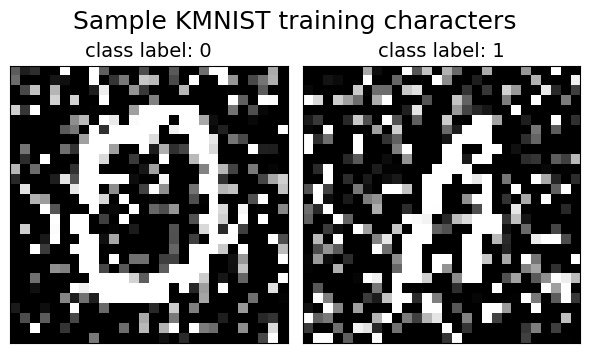

In [8]:
# Visualize Image Data

idx_list = [2, 1]
fig, axes = plt.subplots(1, 2, figsize=(6, 3.5))

plt.suptitle(
    "Sample KMNIST training characters",
    y=1,
    fontsize=18,
)

for idx, ax in zip(idx_list, axes.flat):
    ax.imshow(X_kmnist_train[idx], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(
        "class label: {}".format(y_kmnist_train[idx]),
        fontsize=14,
    )

plt.tight_layout()

Now let's build a fully-connected network in a similar way to what we've done in HW2. We will use only dense layers and apply some of the regularization methods.

In [9]:
# Helper functions to print training history and test results

def plot_hist(model, title=None):
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs[0].plot(model.history.history['loss'], label='train')
    axs[0].plot(model.history.history['val_loss'], label='val')
    axs[0].axvline(np.argmin(model.history.history['val_loss']), c='k', ls=':', label='final model')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('BCE Loss')
    axs[0].legend()
    axs[1].plot(model.history.history['accuracy'], label='train')
    axs[1].plot(model.history.history['val_accuracy'], label='val')
    axs[1].axvline(np.argmin(model.history.history['val_loss']), c='k', ls=':', label='final model')
    axs[1].legend()
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('ACC')
    plt.suptitle(title)


def print_test_results(model_name, test_results):
    print(f"{model_name} performance on test set:\n\t"
          +f"Test Loss: {test_results[0]:.4f}\n\tTest Accuracy: {test_results[1]:.4f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1

2025-03-07 07:06:01.463754: I external/local_xla/xla/service/service.cc:168] XLA service 0x14877cb3cc10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-07 07:06:01.463787: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-03-07 07:06:01.469436: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-07 07:06:01.570595: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1741349161.639212   11170 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


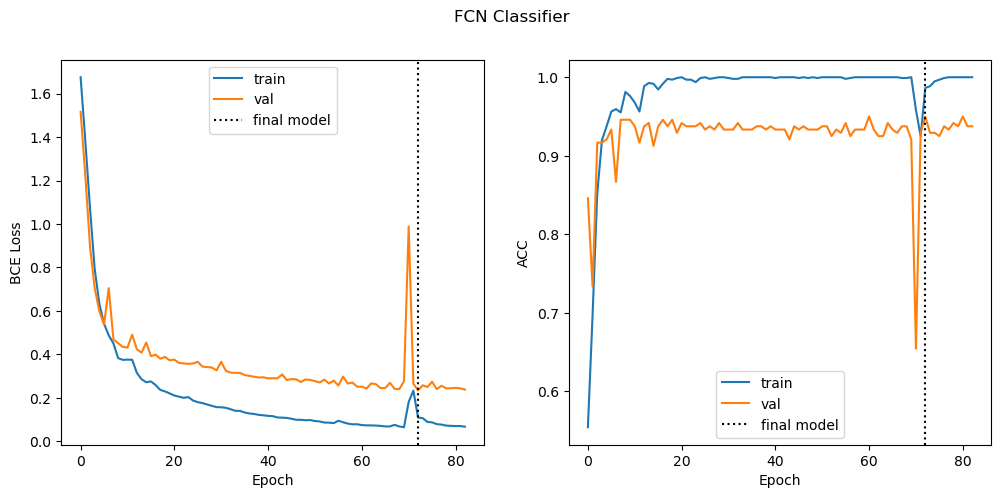

In [10]:
# Fit a fully-connected model with some regularization

# regularization parameters
dropout = 0.1
kernel_weight = 0.003
bias_weight = 0.003

# create fully-connected network with regularization and dropout
fcn_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(784,)),
        tf.keras.layers.Dense(
            100, activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(kernel_weight),
            bias_regularizer=tf.keras.regularizers.l2(bias_weight),
        ),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(
            100, activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(kernel_weight),
            bias_regularizer=tf.keras.regularizers.l2(bias_weight),
        ),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(
            100, activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(kernel_weight),
            bias_regularizer=tf.keras.regularizers.l2(bias_weight),
        ),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

fcn_model.summary()

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# compile model
fcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

# fit model using the augmented training set
fcn_model.fit(X_kmnist_train.reshape(-1, 784), 
              y_kmnist_train,
              batch_size=64,
              validation_split=0.2,
              epochs=100,
              verbose=0,
              callbacks=[early_stop]
)

plot_hist(fcn_model, 'FCN Classifier')

In [11]:
print_test_results("Fully-connected network",
                   fcn_model.evaluate(X_kmnist_test.reshape(-1, 784), y_kmnist_test))

63/63 [==============================] - 0s 2ms/step - loss: 0.2669 - accuracy: 0.9185
Fully-connected network performance on test set:
	Test Loss: 0.2669
	Test Accuracy: 0.9185


<div id="baseline" class='exercise'><b>Baseline CNN Classifer</b></div></br>

In [12]:
inputs = Input(shape=X_kmnist_train.shape[1:])
x = Conv2D(64, 2, activation='relu', padding='same')(inputs)
x = MaxPool2D(2)(x)
x = Conv2D(32, 2, activation='relu', padding='same')(x)
x = MaxPool2D(2)(x)
x = Conv2D(16, 2, activation='relu', padding='same')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

baseline_cnn = Model(inputs=inputs, outputs=outputs)
baseline_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 16)          2064

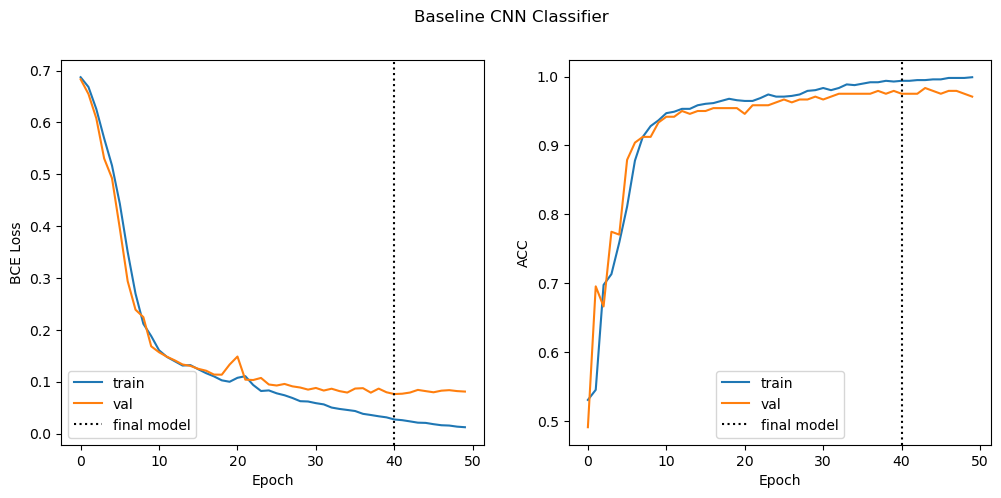

In [13]:
baseline_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
baseline_cnn.fit(X_kmnist_train,
             y_kmnist_train,
             validation_split=.2,
             batch_size=64,
             callbacks=early_stop,
             verbose=0,
             epochs=50)

plot_hist(baseline_cnn, 'Baseline CNN Classifier')

In [14]:
print_test_results("Baseline CNN model",
                   baseline_cnn.evaluate(X_kmnist_test, y_kmnist_test))

63/63 [==============================] - 0s 2ms/step - loss: 0.2037 - accuracy: 0.9355
Baseline CNN model performance on test set:
	Test Loss: 0.2037
	Test Accuracy: 0.9355


<div id="improving" class='exercise'><b>Improving on the Baseline</b></div></br>

In [15]:
# Encoder
input_img = Input(shape=X_kmnist_train.shape[1:])
x = layers.GaussianNoise(stddev=0.1)(input_img)
x = layers.RandomRotation(factor=(-0.025, 0.025))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Now 14x14
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # Now 7x7
encoder = Model(input_img, encoded)

# Decoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)  # Now 14x14
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # Now 28x28
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 gaussian_noise (GaussianNo  (None, 28, 28, 1)         0         
 ise)                                                            
                                                                 
 random_rotation (RandomRot  (None, 28, 28, 1)         0         
 ation)                                                          
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                           

In [16]:
X_kmnist_full = np.vstack((X_kmnist_train, X_kmnist_test))
X_kmnist_full.shape

(3200, 28, 28, 1)

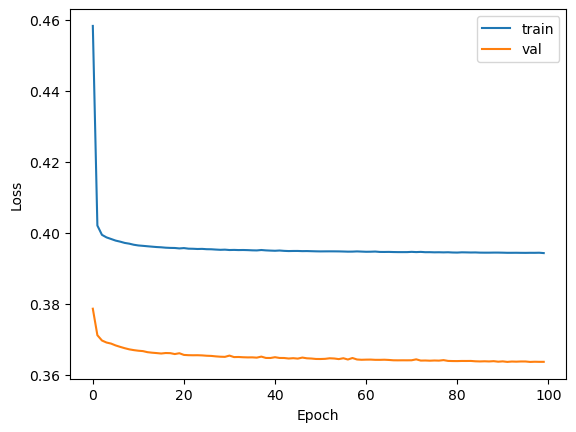

In [17]:
autoencoder.fit(X_kmnist_full,
                X_kmnist_full,
                batch_size=64,
                validation_split=.05,
                callbacks=early_stop,
                verbose=0,
                epochs=100)

plt.plot(autoencoder.history.history['loss'], label='train')
plt.plot(autoencoder.history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

38/38 [==============================] - 0s 4ms/step


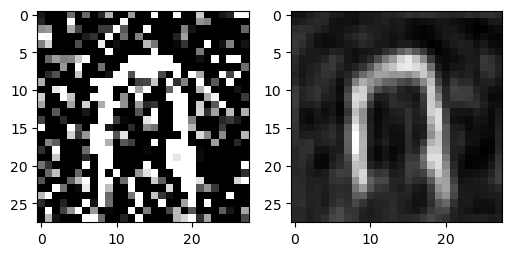

In [18]:
y_pred = autoencoder.predict(X_kmnist_train)

fig, axes = plt.subplots(1, 2, figsize=(6,3.5))
idx = 5
axes[0].imshow(X_kmnist_train[idx], cmap='grey')
axes[1].imshow(y_pred[idx], cmap='grey')

In [19]:
for layer in autoencoder.layers:
    layer.trainable = False

In [20]:
inputs = Input(shape=(X_kmnist_train.shape[1:]))
x = autoencoder(inputs)
x = GaussianNoise(stddev=0.1)(x)
x = RandomRotation(factor=(-.025,.025))(x)
x = Conv2D(256, 2, activation='relu', padding='same')(x)
x = Conv2D(128, 2, activation='relu', padding='same')(x)
x = MaxPool2D(2)(x)
x = Conv2D(64, 2, activation='relu', padding='same')(x)
x = Conv2D(32, 2, activation='relu', padding='same')(x)
x = MaxPool2D(2)(x)
x = Conv2D(16, 2, activation='relu', padding='same')(x)
x = Conv2D(8, 2, activation='relu', padding='same')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_3 (Functional)        (None, 28, 28, 1)         121857    
                                                                 
 gaussian_noise_1 (Gaussian  (None, 28, 28, 1)         0         
 Noise)                                                          
                                                                 
 random_rotation_1 (RandomR  (None, 28, 28, 1)         0         
 otation)                                                        
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 256)       1280      
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 128)       1312

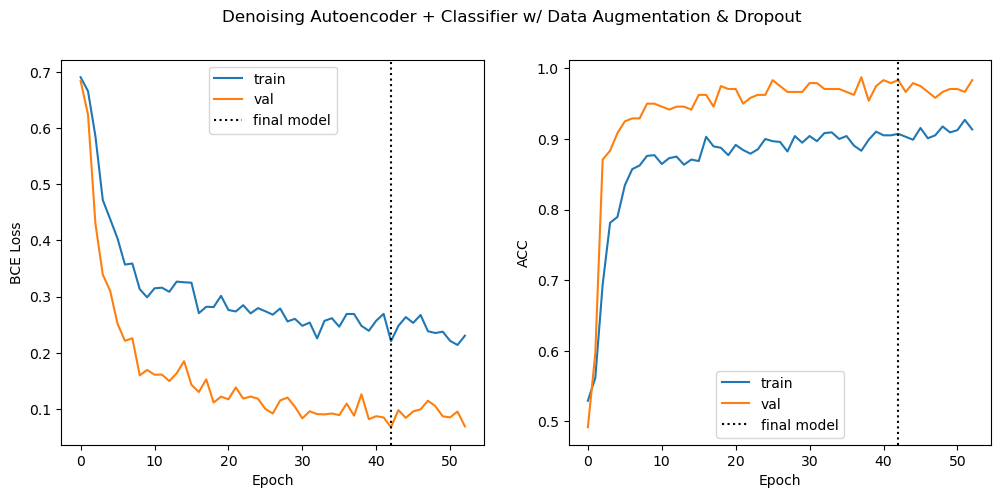

In [21]:
model.fit(X_kmnist_train,
          y_kmnist_train,
          validation_split=0.2,
          batch_size=64,
          epochs=100,
          verbose=0,
          callbacks=early_stop)

plot_hist(model, "Denoising Autoencoder + Classifier w/ Data Augmentation & Dropout")

In [22]:
print_test_results("Denoising Autoencoder + Classifier",
                   model.evaluate(X_kmnist_test, y_kmnist_test))

63/63 [==============================] - 0s 4ms/step - loss: 0.1433 - accuracy: 0.9415
Denoising Autoencoder + Classifier performance on test set:
	Test Loss: 0.1433
	Test Accuracy: 0.9415


In [23]:
# Start with the encoder
model2 = Sequential(encoder)

# Add classification layers
model2.add(layers.Flatten())  # Flatten the output of the encoder
model2.add(layers.GaussianNoise(stddev=0.01))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 7, 7, 32)          93536     
                                                                 
 flatten_3 (Flatten)         (None, 1568)              0         
                                                                 
 gaussian_noise_2 (Gaussian  (None, 1568)              0         
 Noise)                                                          
                                                                 
 dense_10 (Dense)            (None, 128)               200832    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                      

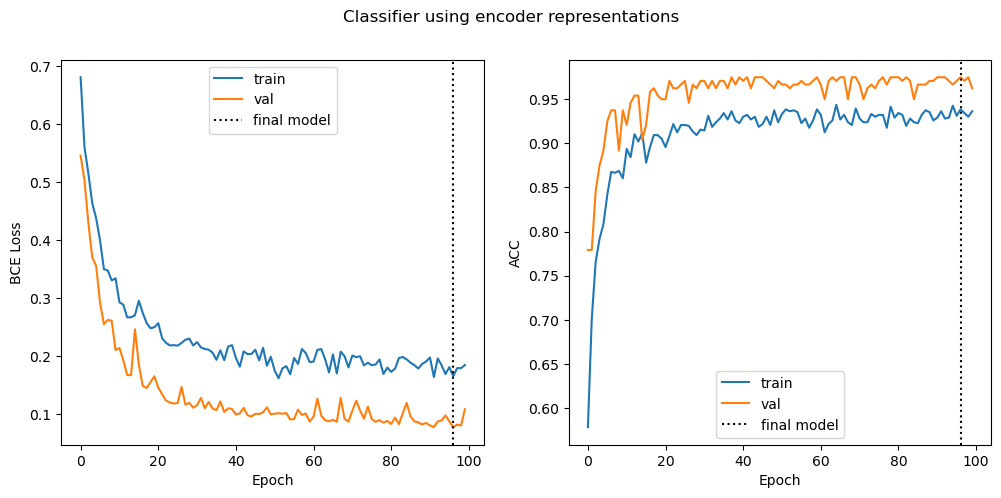

In [24]:
model2.fit(X_kmnist_train,
          y_kmnist_train,
          batch_size=64,
          validation_split=0.2,
          epochs=100,
          verbose=0,
          callbacks=early_stop)
plot_hist(model2, "Classifier using encoder representations")

In [25]:
print_test_results("Denoising Autoencoder + Classifier",
                   model2.evaluate(X_kmnist_test, y_kmnist_test))

63/63 [==============================] - 0s 1ms/step - loss: 0.2027 - accuracy: 0.9135
Denoising Autoencoder + Classifier performance on test set:
	Test Loss: 0.2027
	Test Accuracy: 0.9135


<a id='tfdatasets'></a>

## Tensorflow Datasets [^](#contents "Back to Contents")
<img src='https://3.bp.blogspot.com/-d-nV7xJRmpw/Xo328dcAx3I/AAAAAAAAC7Q/qlqJOle6XIosJ3CGIDJ04F3Voh1iXDg0gCLcBGAsYHQ/s1600/TF_FullColor_Icon.jpg' width='150'>

TensorFlow Datasets (TFDS) is a collection of datasets ready to use, with TensorFlow or other Python ML frameworks. These datasets are exposed as `tf.data.Dataset` objects, enabling easy-to-use and high-performance input pipelines.

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [27]:
# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

<div id="loadds" class='exercise'><b>Loading Datasets</b></div></br>

TFDS gives us access to dozens of research quality datasets with the simple `tfds.load` method.<br>
An extensive catalogue of datasets can be seen <a href='https://www.tensorflow.org/datasets/catalog/overview'>here</a>. You can even <a href='https://www.tensorflow.org/datasets/add_dataset'>write your own custom dataset</a>.

### <div style='font-size: 150%'>🐎 or 🧍?</div>

But it doesn't mean you should just because you can. The *bizzare* <a href='http://laurencemoroney.com/horses-or-humans-dataset'>Horses or Humans</a> dataset may just be an example of this.<br>
Our call to `tfds.load` will use several arguments:
- `name`: (str) the dataset to load (you can look these up in the above catalogue)
- `split`: (list) some datasets have pre-specified splits; this list defines which splits to load
- `shuffle_files`: (bool) files are loaded in random order
- `as_supervised`: (bool) loads labels if dataset has them
- `with_info`: (bool) also returns an DatasetInfo object with details about the loaded dataset


In [28]:
tfds.disable_progress_bar()

In [29]:
(ds_train, ds_test), ds_info = tfds.load(name="horses_or_humans", split=['train', 'test'],
                                         shuffle_files=True, as_supervised=True, with_info=True, )

The `ds_info` we got from using `with_info=True` gives us a great overview of some facts about the dataset.

In [30]:
ds_info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_dir='/shared/home/haz130/tensorflow_datasets/horses_or_humans/3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",

<div id="dsobj" class='exercise'><b>The Dataset Object</b></div></br>

We'll be working with closely with the `tf.data.Dataset` object so we should learn more about its methods and structure.

**Some Python Arcana: Iterables & Iterators**:<br>

The `tf.data.Dataset` object is an *iterable*, which means it implements an `__iter__` method which returns an *iterator* object.<br>
An *iterator* is an object that implements a `__next__` method which returns the next element in the iterator!

In [31]:
# create iterator from iterable
my_iter = iter(ds_train)
my_iter

In [32]:
# get next element from iterator
next_one = next(my_iter)
print(f'Each element in the iterator is of type {type(next_one)} with length {len(next_one)}')

Each element in the iterator is of type <class 'tuple'> with length 2


In [33]:
# display element from iterator
next_one

(<tf.Tensor: shape=(300, 300, 3), dtype=uint8, numpy=
 array([[[185, 172, 152],
         [185, 172, 151],
         [185, 172, 151],
         ...,
         [222, 207, 186],
         [222, 207, 185],
         [221, 206, 185]],
 
        [[185, 172, 151],
         [184, 172, 151],
         [184, 171, 151],
         ...,
         [223, 208, 186],
         [222, 207, 186],
         [222, 207, 186]],
 
        [[184, 171, 151],
         [184, 171, 151],
         [184, 171, 150],
         ...,
         [224, 209, 187],
         [223, 208, 187],
         [222, 208, 186]],
 
        ...,
 
        [[192, 181, 161],
         [192, 180, 161],
         [191, 180, 160],
         ...,
         [224, 209, 188],
         [224, 210, 188],
         [224, 210, 189]],
 
        [[192, 180, 161],
         [191, 180, 160],
         [190, 179, 159],
         ...,
         [224, 210, 189],
         [225, 210, 189],
         [225, 211, 189]],
 
        [[191, 180, 160],
         [190, 179, 159],
         [190,

Inspecting this tuple we see the 1st element is our image and the 2nd is the lable. Let's visualize the image.

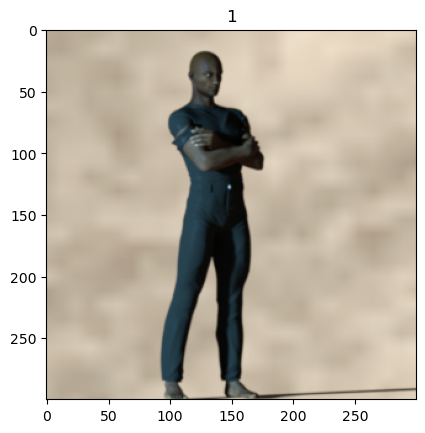

In [34]:
image, label = next_one
plt.imshow(image)
plt.title(int(label));

It appears humans are the positive class. Let's make a dictionary to map class labels to strings.

In [35]:
# create human interperatable class names
class_names = {0: 'horse', 1: 'human'}

**Iterating**

Iterables can be looped over with a `for` loop. And while you *can* loop over the `Dataset` iterable object itself it is more common to first use the `as_numpy_iterator()` method if running TF in eager mode.

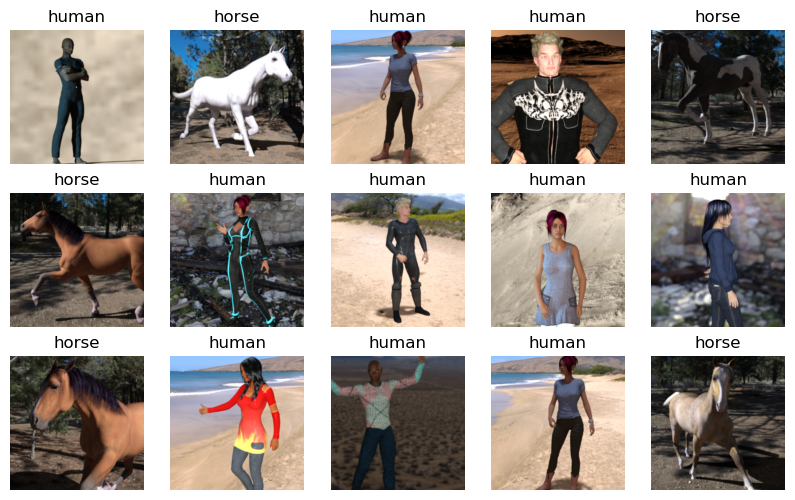

In [36]:
rows = 3
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(10,6))
for ax, (img, label) in zip(ax.ravel(), ds_train.as_numpy_iterator()):
    # break when no more axes left
    if ax is None:
        break
    ax.imshow(img)
    ax.set_title(class_names[label])
    ax.axis('off')

The above method works, but it would be a nuisance to have to always write out all that code just to inspect our datasets.

Luckily, `tfds` has a much faster way to do this with the `show_examples()` method.

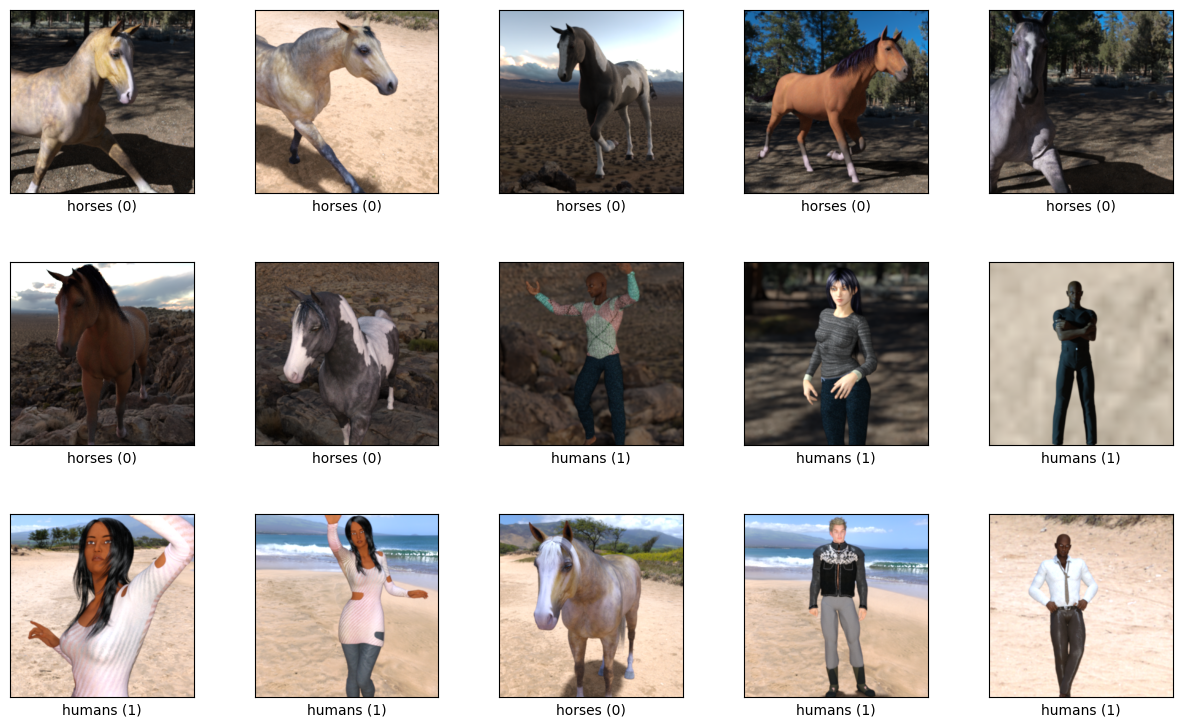

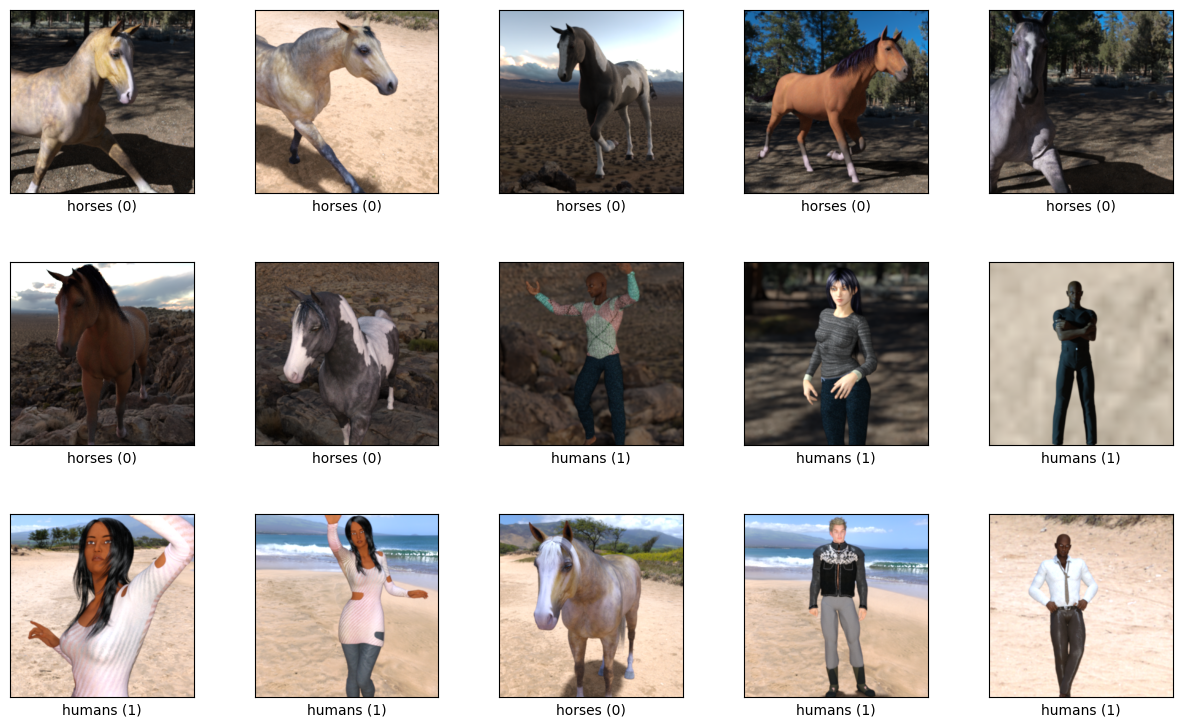

In [37]:
# train examples
tfds.show_examples(ds_train, ds_info, rows=rows, cols=cols)

2025-03-07 07:07:03.124360: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


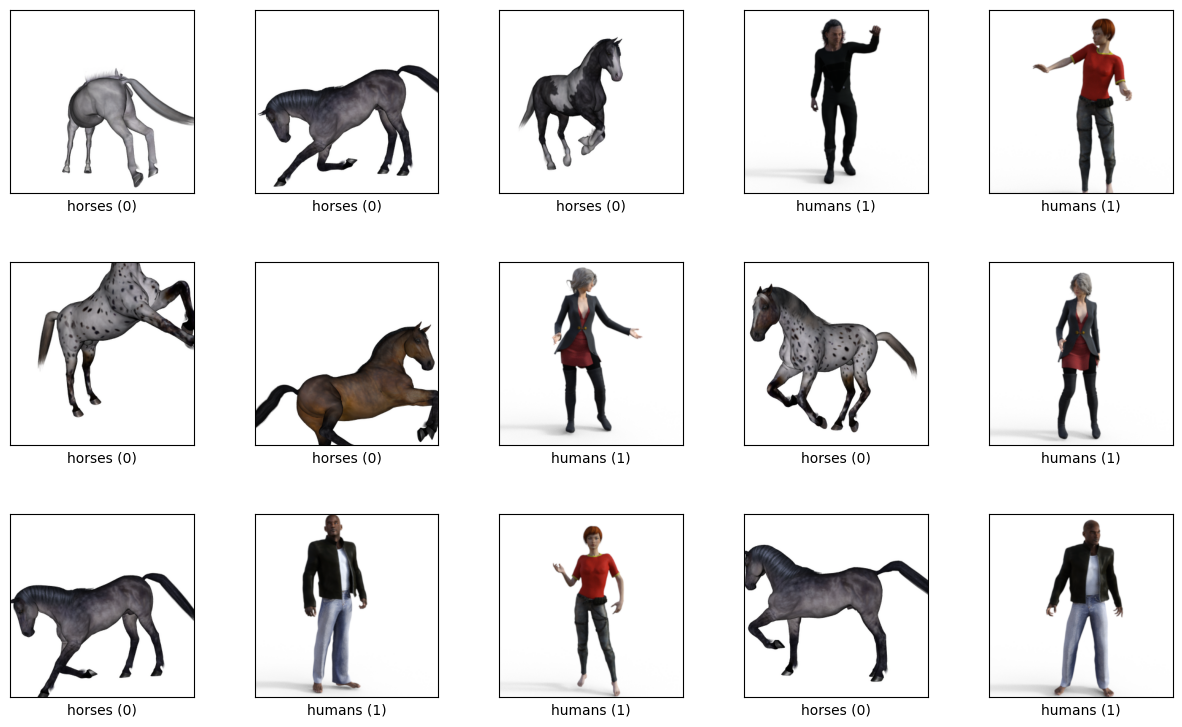

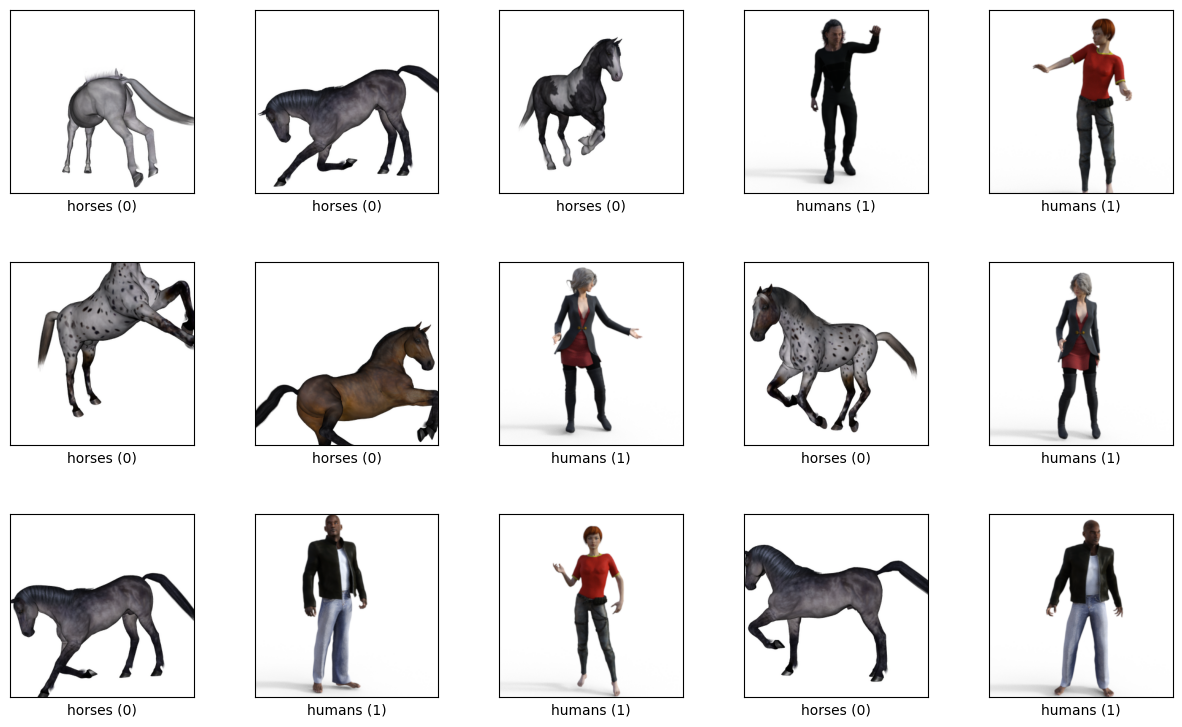

In [38]:
# test examples
tfds.show_examples(ds_test, ds_info, rows=rows, cols=cols)

**Q:** Do you notice anything strange about the test examples? 🤔

<div id="take" class='exercise'><b>Take, Cardinality, & Batch</b></div></br>

**Take**

We can use the `take()` method to return a **subset** of the original `Dataset` object of a desired **cardinality**.

In [39]:
# get a subset with cardinality 2
my_subset = ds_train.take(2)

**Cardinality**

It's true that we can check the length of a datset with `len()`

In [40]:
# one way to find a Dataset's length
len(my_subset)

2

But this is inefficient  for larger datasets.<br>
It is preferable to use the `cardinality()` method. This returns a Tensor.

In [41]:
# a better way
cardinality = my_subset.cardinality()
print(f'Cardinality Type: {type(cardinality)}')

Cardinality Type: <class 'tensorflow.python.framework.ops.EagerTensor'>


It looks a bit strange when displayed.

In [42]:
# displaying an EagerTensor
cardinality

<tf.Tensor: shape=(), dtype=int64, numpy=2>

But it behaves just like an integer.

In [43]:
# no surprises here!
(cardinality + 2) == 4

<tf.Tensor: shape=(), dtype=bool, numpy=True>

And if you really want to, you can always convert it to a `numpy.int64` object which prints nicely.

In [44]:
# convert to nump.int64
cardinality.numpy()

2

**Batch**

To get the benefits of <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>**stochastic gradient descent**</a> (SGD) during training, we'd like to feed elements from the dataset into our model in batches.<br>
This is handled by the `batch()` method.

**Q:** What are some benefits of SGD? 🤔

In [45]:
BATCH_SIZE = 32
num_batch = ds_train.cardinality() / BATCH_SIZE
print(f'Number of Potential Batches of size {BATCH_SIZE}:', num_batch.numpy())
num_batched_produced = ds_train.batch(BATCH_SIZE).cardinality()
print(f'Number of Batches of size {BATCH_SIZE} Produced:', num_batched_produced.numpy())

Number of Potential Batches of size 32: 32.09375
Number of Batches of size 32 Produced: 33


**Q:** Why don't these numbers match? What's going on? 🤔

The batched dataset is itself a `Dataset`, but now it's an iterable that produces batches.<br>
In a **supervised** situation like ours, each batch is a tuple.

In [46]:
# inspect first batch
my_batch = ds_train.batch(BATCH_SIZE).as_numpy_iterator().next()
print(f'Each batch is of type {type(my_batch)} with length {len(my_batch)}')

Each batch is of type <class 'tuple'> with length 2


The 1st element of the tuple are all the images in the batch.

In [47]:
# batch images
my_batch[0].shape

(32, 300, 300, 3)

The 2nd element are all the labels in the batch.

In [48]:
# batch labels
my_batch[1].shape

(32,)

**Note:** The batch of images and labels above are both `numpy` arrays. This is because we used `as_numpy_iterator()` on our batched dataset. This is why we were able to use the `shape` attribute. here.

We can also strengthen our intuition about the structure of the batched dataset by iterating over the batches and displaying the first image in each.

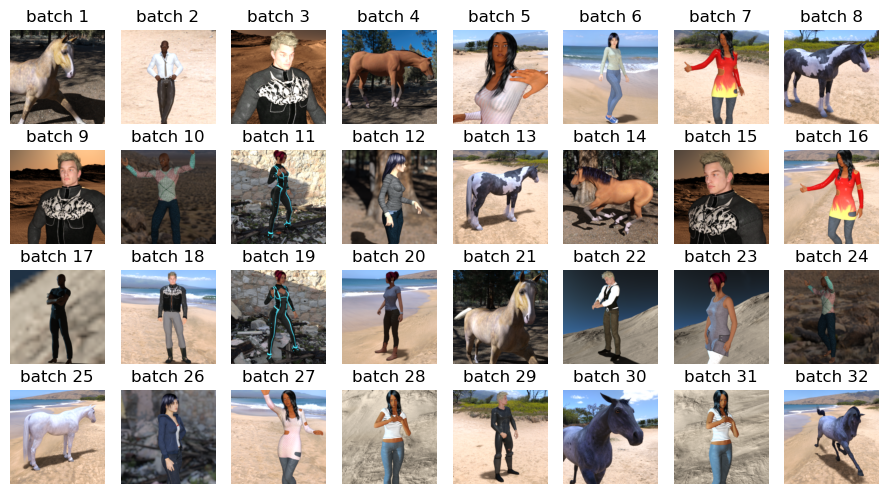

In [49]:
# display the first image in each batch
fig, axs = plt.subplots(4, 8, figsize=(9,5))
axs = axs.ravel()
for i, (img_batch, label_batch) in enumerate(ds_train.batch(BATCH_SIZE, drop_remainder=True)):
    for (img, label) in zip(img_batch, label_batch):
        axs[i].imshow(img)
        axs[i].set_title(f'batch {i+1}')
        axs[i].axis('off')
        break
plt.tight_layout()

<div id="cache" class='exercise'><b>Cache, Prefetch & Shuffle</b></div></br>

There are helpful methods we can use to optimize the training process. Most of these descriptions are adapted from the TensorFlow documentation. As always, the documentation is the best place to go if you'd like a deeper understanding.

**<a href="https://www.tensorflow.org/guide/data_performance#caching">`Cache`</a>** caches a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch. (perhaps not a good idea for enormous datasets)

**`Prefetching`** overlaps the preprocessing and model execution of a training step. While the model is executing training steps, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data."

**<a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle">`Shuffle`</a>** Randomly shuffles the elements of this dataset.

**Note:** cache will produce exactly the same elements during each iteration through the dataset. If you wish to randomize the iteration order, make sure to call shuffle after calling cache.

And of course we can chain all these commands together!

(-0.5, 299.5, 299.5, -0.5)

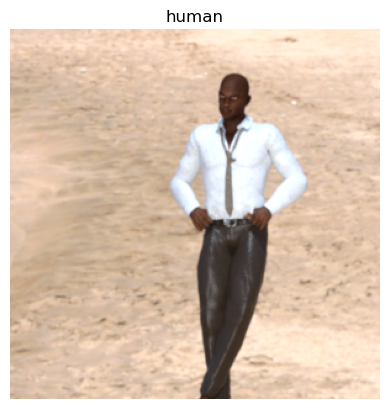

In [50]:
images, labels = ds_train.cache()\
                         .shuffle(buffer_size=ds_train.cardinality(), seed=SEED, reshuffle_each_iteration=True)\
                         .batch(BATCH_SIZE).prefetch(AUTOTUNE)\
                         .as_numpy_iterator().next() # one batch
# show first image in batch
plt.imshow(images[0])
plt.title(class_names[labels[0]])
plt.axis('off')

<div id="dspreproc" class='exercise'><b>Preprocessing with Datasets</b></div></br>

Often, we'll want to **preprocess** our data in some way before feeding it into our model.<br>
We can use use the `Dataset` object's `map` method to perform arbitrary functions on the elements of the dataset.

Because the result of the `map` operation is itself a dataset object, we can continue to chain these commands one after another.<br>
Here we are normalizing and resizing our images as part of the preprocessing stage using functions of our own design. 

In [51]:
H = W = 224

def normalize_img(img, label):
    return tf.cast(img, tf.float32)/255.0, label

def resize_img(img, label):
    return tf.image.resize(img, size=[H, W]), label

def preprocess(img, label):
    img, label = normalize_img(img, label)
    img, label = resize_img(img, label)
    return img, label

ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)

<div id="dataaug" class='exercise'><b>Data Augmentation</b></div></br>


We almost always wish we had *more data*! But it can be expensive and time consuming to gather and label new data.<br>
So why not **simulate new data?** We can accomplish this by creating variants of our original data. 

In the case of images this is very intuitive. Simply rotate your picture of a horse. It's still a horse, but the rotated image is likely different from anything in your data original. As long as the simulated data is not *too* different from the sort of example's we'd like to learn, this can help our model generalize better to previously unseen examples not in the original dataset.

In [52]:
import tensorflow_addons as tfa

def random_rotate(image, label):
    """Dataset pipe that rotates an image, helper function to augment below"""
    shape = image.shape
    deg = tf.random.uniform([],-10.,10.)
    image = tfa.image.rotate(image, deg/180.*np.pi, interpolation="BILINEAR")
    image.set_shape((shape))
    label.set_shape(())
    return image, label

def random_zoom(image, label):
    """Dataset pipe that zooms an image, helper function to augment below"""
    rand_float = tf.random.uniform([],10,20)
    rand_int = tf.cast(rand_float, tf.int32)
    image = tf.image.resize_with_crop_or_pad(image,
                                             H + H//rand_int,
                                             W + W//rand_int)
    image = tf.image.random_crop(image, size=[H, W, 3])
    return image, label
    
def augment(image, label):
    """Function that randomly alters an image with
       flipping, rotation, zoom, and contrast adjustment"""
    image = tf.image.random_flip_left_right(image)
    image, label = random_rotate(image, label)
    # image, label = random_zoom(image, label)
    # image = tf.image.random_contrast(image, lower=.95, upper=1.)
    
    return image, label

/shared/home/haz130/.local/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Here are just a few examples created using the augmentation functions defined above!

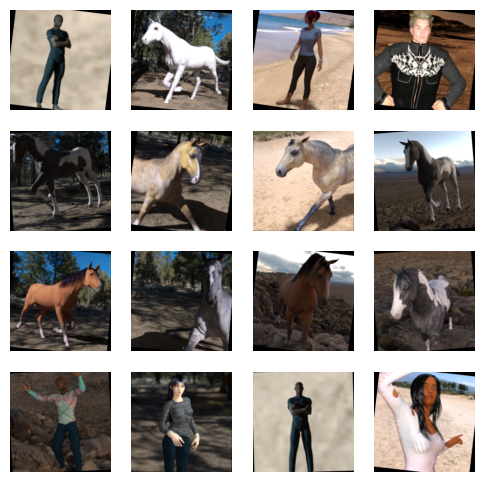

In [53]:
# display a batch of altered images
fig, axs = plt.subplots(4,4, figsize=(6,6))
aug_batch = ds_train.map(augment, num_parallel_calls=AUTOTUNE).take(16)
for ax, (img, label) in zip(axs.ravel(), aug_batch):
    ax.imshow(img)
    ax.axis('off')

Data augmentation is an important topic and it will be revisited several times throughout the course!

<div id="val_split" class='exercise'><b>Creating a Validation Set</b></div></br>

We can see from `ds_info` above that this dataset had predefined train and test sets. We loaded both.

Some TF datasets also have a validation set. Others have only train. We'd like to use a validation set while training our model. And in situations where your data set only has a train set it will be important to know how to create new splits. As of Tensorflow 2.10 this is made easy with the `tf.keras.utils.split_dataset()` methods which works similar to the train_test_split in SKLearn.

In [54]:
left_ds, right_ds = keras.utils.split_dataset(ds_train, left_size=0.8)

In [55]:
left_ds.cardinality() + right_ds.cardinality() == ds_train.cardinality()

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<a id='transfer_learning'></a>
## Transfer Learning [^](#contents "Back to Contents")

Here we can see an example of transfer learning where we use the pretrained MobileNet model as the base of our classifier.

<div id="mobilenet" class='exercise'><b>MobileNet</b></div></br>

In [56]:
ds_train, ds_info = tfds.load('horses_or_humans', split='train', as_supervised=True, with_info=True)
ds_test = tfds.load('horses_or_humans', split='test', as_supervised=True)
ds_train, ds_val = keras.utils.split_dataset(ds_train, left_size=0.8)

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

ds_train = ds_train.map(preprocess).map(augment).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [57]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                include_top=False,
                                                weights='imagenet')

# Freeze the base model's layers to prevent them from being updated during training
base_model.trainable = False

# Add custom layers on top of MobileNet
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = keras.layers.Dense(1024, activation='relu')(x)
# Add a logistic layer for binary classification
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [58]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [59]:
model.fit(ds_train,
          validation_data=ds_val,
          epochs=10)

Epoch 1/10
26/26 [==============================] - 5s 96ms/step - loss: 0.1521 - accuracy: 0.9465 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 2/10
26/26 [==============================] - 2s 74ms/step - loss: 0.0075 - accuracy: 0.9988 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 3/10
26/26 [==============================] - 2s 74ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 4/10
26/26 [==============================] - 2s 74ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 5/10
26/26 [==============================] - 2s 75ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/10
26/26 [==============================] - 2s 74ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - 2s 74ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 8/10
26

In [60]:
model.evaluate(ds_test)

8/8 [==============================] - 0s 22ms/step - loss: 0.0156 - accuracy: 0.9961


[0.015627508983016014, 0.99609375]